# Fundamentos de Comunicaciones Inalámbricas - TP 2

Datos:
-La frecuencia de la portadora fc es de 1 GHz.
-La distancia entre el transmisor y el receptor (Tx y Rx en la Fig. 1, respectivamente), es del
orden del kilometro.
-La distancia entre “clusters” (d3 en la Fig. 1) es del orden de los cientos de metros.
-El diametro de los “clusters” ( ´ d2 en la Fig. 1) es del orden de las decenas de metros.
-La distancia media entre los reflectores o “scatterers” (d1 en la Fig. 1) es del orden de los
metros.

In [44]:
#Librerias
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pylab 

In [45]:
#Datos
Fc = 1e9    #[Hz]
Distancia_tx_rx = 1e3   #[m]
Distancia_entre_clusters = 1e2  #[m]
Diametro_de_clusters = 1e1  #[m]
Distancia_media_entre_scatterers = 1    #[m]
c = 3e8   #[m/s]

![Image: image](Canal.png)

# Funciones para simular un Canal Inalámbrico

In [46]:
def genScat(Ns,Rc,Cc):
    """ FUNCTION genScat(Ns, Rc, Cc)
    Esta funcion devuelve un arreglo de N x 2. Cada fila representa la posicion
    (x,y) de un reflector en el plano. Estos reflectores estan distribuidos
    de un modo aleatorio uniforme adentro de circulos con radios dados por el 
    vector Rc (radios de los clusters) y dentro de cada cluster hay una cantidad
    de reflectores dadas por el vector de cantidades de reflectores/cluster Ns.
    Cc es un arreglo con una cantidad de filas igual a la cantidad de clusters
    y cuyas filas son las posiciones (x,y) del centro de los clusters.
    Ejemplo:
    --------
    Ns = [20, 20, 20];  
    Rc = [20, 20, 20];  
    Cc = [100,0.0 ; 300,0.0 ; 500,0.0];
    genScat(Ns,Rc,Cc) en este caso genera 20 reflectores al azar agrupados en 
    3 clusters de 20 metros de diametro centrados en (100,0), (300,0) y (500,0).
    """
    S = np.empty((sum(Ns),2))
    Nsum = [int(sum(Ns[:i])) for i in range(len(Ns)+1)]
    for i in range(len(Nsum)-1):
        S[Nsum[i]:Nsum[i+1],:] = genClust(Ns[i])*Rc[i]+np.repeat([Cc[i,:]],Ns[i], axis=0)
    return S


def genClust(N):
    """ genClust(N)
    Genera un cluster de N posiciones uniformemente distribuidas en un
    círculo de diámetro unitario. Retorna un arreglo de N x 2 adonde cada
    fila es una posición (x,y)
    """
    Clust = np.empty((N,2))
    n = 0
    while n < N:
        X = np.random.rand(2)-np.array([0.5,0.5])
        if X.dot(X) < 0.25:
            Clust[n,:]=X
            n = n + 1
    return Clust


def genDists(S, posTx, posRx):
    """ genDists(S,posTx,posRx)
    Recibe un arreglo de N x 2 adonde cada fila describe la
    posicion (x,y) de N reflectores y retorna un arreglo Dsts con N distancias entre
    posTx y posRx (vectores (x,y) que describen posiciones de Tx y Rx)
    medidas como rectas que unen los puntos Tx, reflector y Rx.
    Tambien se retorna un arreglo D_ref_Rx con las N distancias entre reflector
    y Rx.
    Por convencion todas las distancias son en metros. 
    """

    Dsts = np.empty(S.shape[0])
    D_ref_Rx = np.empty(S.shape[0])
    for i in range(len(Dsts)):
        a = posTx - S[i,:]
        b = posRx - S[i,:]
        Dsts[i] = np.sqrt(a.dot(a)) + np.sqrt(b.dot(b))
        D_ref_Rx[i] = np.sqrt(b.dot(b))
    return Dsts, D_ref_Rx


def genhl(Dsts, fc, W, a_i, oversample=1, margen=0):

    """ genhl(Dsts, fc, W, a_i, oversample, margen)
    Esta funcion produce la respuesta impulsiva discreta equivalente banda base 
    del canal correspondiente a todos los caminos con distancias dadas por el 
    vector Dsts, una frecuencia central fc, un ancho de banda W, atenuaciones 
    a_i (tambien un vector con las atenuaciones de cada camino).
    oversample es un parametro que debe ser un nro entero mayor o igual a 1 y 
    que sirve para generar puntos intermedios entre las muestras (para simular 
    el comportamiento "analogico" del canal)
    margen: la respuesta se calcula para floor(margen)/2 muestras anteriores al
    primer eco (o camino) recibido del canal e idem para el ultimo recibido. 
    """

    if ((oversample-np.floor(oversample))!=0) | (oversample<1):
        raise ValueError('El parametro oversample debe ser un entero mayor o igual a 1.')

    c = 3e8                # m/s
    Rts = Dsts/c           # retardos
    GroupRet = min(Rts)
    Td = max(Rts)-GroupRet # delay spread

    RtsRel = Rts - GroupRet

    hl = np.empty(int(np.floor(Td*W*oversample)+margen*oversample+1),dtype='complex128')  
                                                        # h_l con l=0,1,...,floor(Td*W*oversample)+margen
    a_ib = a_i * np.exp(-1j*2*np.pi*fc*Rts)
    for l in range(len(hl)):
        hl[l] = (np.sinc(l/oversample - np.floor(margen/2) - RtsRel*W)).dot(a_ib.T)
    tt = np.arange(len(hl))/W/oversample - np.floor(margen/2)/W + GroupRet
    
    return hl, tt


def delaySpread(Dsts):
    """ delaySpread(Dsts)
    Recibe como parametro un vector Dsts de distancias (en metros)
    y retorna el delay spread Td (en segundos) entre esas distancias.
    """ 
    Rts = Dsts/3e8
    return max(Rts)-min(Rts)

In [47]:
def MAX(vector,Nmin,Nmax):
    maximo = 0
    posicion_max = 0
    for i in range(Nmin,Nmax,1):
        if maximo < vector[i]:
            maximo = vector[i]
            posicion_max = i
    return posicion_max

def MIN(vector,Nmax):
    minimo = vector[0]
    posicion_min = 0
    for i in range(Nmax):
        if minimo > vector[i]:
            minimo = vector[i]
            posicion_min = i
    return posicion_min

# Escenario del canal

In [48]:
Ns=np.array([20, 20, 20])   #nro. de reflectores por cluster
Rc=np.array([Diametro_de_clusters, Diametro_de_clusters, Diametro_de_clusters])   #diametro de los clusters en metros
Cc=np.array([[-50.0,250.0], [150,250.0], [200,250.0]])  #centros de los clusters
posTx = np.array([0,0])
posRx = np.array([0.0,500.0])
vmax = 60000/3600   #[m/s]
#K = 0.0    #K-factor, para darle más ganancia a uno de los caminos, es decir, a una de las componentes de a_i

# Generamos "clusters" y respectivas distancias/atenuaciones
S = genScat(Ns,Rc,Cc)
Dsts,_ = genDists(S,posTx,posRx)
a_i = -1*np.ones(np.size(Dsts))

1) Proponga tres anchos de banda W1 < W2 < W3 tales que
(i) toda la informacion del canal este concentrada en un único “tap”, 

22023.30699819673
Tc_experimental =  48.00644146139723


C:\Users\tomas\AppData\Local\Temp\ipykernel_7460\609905267.py:15: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(td_1*1e6,abs(hd_1)**2,'r')


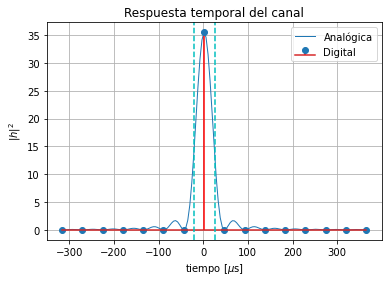

In [107]:
#Único tap, estaré en el caso de flat fading, caso W1

# generando la respuesta impulsiva del canal
# ha_i --> rtas "analógica" (emulada usando oversample de 10 veces)
# hd_i --> rtas digitales (sin oversample)
# ta_i y td_i son los instantes de tiempo para cada valor de la respuesta
margen = 15
oversample = 10
ha_1, ta_1 = genhl(Dsts, Fc, 0.01/delaySpread(Dsts),a_i, oversample, margen)
hd_1, td_1 = genhl(Dsts, Fc, 0.01/delaySpread(Dsts),a_i, 1, margen)
print(0.01/delaySpread(Dsts))

plt.figure()
plt.plot(ta_1*1e6,abs(ha_1)**2,linewidth=1)
plt.stem(td_1*1e6,abs(hd_1)**2,'r')
plt.xlabel('tiempo [$\mu$s]')
plt.ylabel('$|h|^2$')
plt.legend(['Analógica', 'Digital'])
plt.title('Respuesta temporal del canal')
plt.grid()

#Medicion del tiempo de coherencia
plt.axvline(td_1[8]*10**6*1/2+3.6,c = 'c',linestyle = '--')
plt.axvline(td_1[6]*10**6*1/2+1,c = 'c',linestyle = '--')
Tc_exp_1 = np.abs(td_1[8]*10**6*1/2+3.6) + np.abs(td_1[6]*10**6*1/2+1)
print("Tc_experimental = ",Tc_exp_1)


Único tap, caso de flat fading, caso W1, pero en el dominio frecuencial

Wc_experimental_1 = 14920.0 Hz


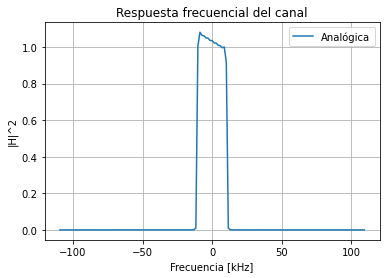

In [140]:
#Calculo de la FFT
Ha_1 = np.fft.fft(ha_1)
Ha_1 = np.fft.fftshift(Ha_1)
Ha_1 = Ha_1/np.max(Ha_1)

#Genero el vector de frecuencias
fa_1 = np.fft.fftshift(np.fft.fftfreq(Ha_1.size, d=np.diff(ta_1)[0]))
fa_1 = fa_1/1000
plt.figure()
plt.plot(fa_1,np.abs(Ha_1)**2)
plt.xlabel('Frecuencia [kHz]')
plt.ylabel('|H|^2')
plt.title('Respuesta frecuencial del canal')
plt.grid()
plt.legend(['Analógica', 'Digital'])

#Medicion de la banda de coherencia
# plt.axvline(-11,c = 'r',linestyle = '--')
# plt.axvline(11,c ='r',linestyle = '--')
Wc_exp_1 = np.abs(14920 + np.abs(-14920))/2
print("Wc_experimental_1 =",Wc_exp_1,"Hz")

(ii) que el sistema E/S pueda resolver los clusters pero no los caminos que los conforman y 

11011653.499098366
Tc_experimental =  1.5135480487132384e-07


C:\Users\tomas\AppData\Local\Temp\ipykernel_7460\2965965005.py:9: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(td_2*1e6,abs(hd_2)**2,'r')


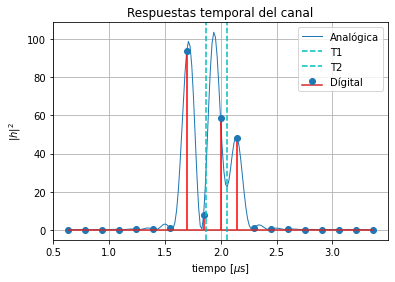

In [74]:
margen = 15
oversample = 10
ha_2, ta_2=genhl(Dsts, Fc, 3/delaySpread(Dsts),a_i, oversample, margen)
hd_2, td_2=genhl(Dsts, Fc, 3/delaySpread(Dsts),a_i, 1, margen)
print(5/delaySpread(Dsts))

plt.figure()
plt.plot(ta_2*1e6,abs(ha_2)**2,linewidth=1)
plt.stem(td_2*1e6,abs(hd_2)**2,'r')
#plt.axvline(td_2[7]*10**6,c = 'c',linestyle = '--')
#plt.axvline(td_2[13]*10**6,c = 'c',linestyle = '--')
plt.axvline(td_2[8]*10**6+0.02,c = 'c',linestyle = '--')
plt.axvline(td_2[9]*10**6+0.06,c = 'c',linestyle = '--')
plt.xlabel('tiempo [$\mu$s]')
plt.ylabel('$|h|^2$')
plt.title('Respuestas temporal del canal')
plt.grid()
plt.legend(['Analógica', 'T1','T2','Dígital'])

#Medicion del tiempo de coherencia
Tc_exp_2 = np.abs(td_2[8]+0.02e-6 - (td_2[9]+0.02e-6))
print("Tc_experimental = ",Tc_exp_2)

OBS: no es simétrica => para que lado tomo el ancho?
Podría tomar la mitad de lo graficado

Creo que lo de resolver los cluster es con la digitál, no con la señal analógica.
Quizás sea un problema que haya un tap en el medio, que no corresponde a un cluster en sí. En freq me quedan 4 picos.

Wc_experimental_2 = 1485000.0 Hz


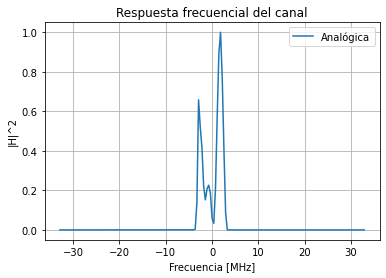

In [89]:
#Calculo de la FFT
Ha_2 = np.fft.fft(ha_2)
Ha_2 = np.fft.fftshift(Ha_2)
Ha_2 = Ha_2/np.max(Ha_2)

#Genero los vectores de frecuencias
fa_2 = np.fft.fftshift(np.fft.fftfreq(Ha_2.size, d=np.diff(ta_2)[0]))

plt.figure()
#No quiero que salta el eje x en 1e7, sino en escala en 1
plt.plot(fa_2/1000000,np.abs(Ha_2)**2)
plt.xlabel('Frecuencia [MHz]')
plt.ylabel('|H|^2')
plt.title('Respuesta frecuencial del canal')
plt.grid()
plt.legend(['Analógica'])

#Medicion de la banda de coherencia
# plt.axvline(2.485,c = 'r',linestyle = '--')
# plt.axvline(1,c ='r',linestyle = '--')
Wc_exp_2 = 2.485e6 - 1e6
print("Wc_experimental_2 =",Wc_exp_2,"Hz")
#plt.xlim(0,3)

(iii) que el sistema E/S pueda resolver buena parte de los caminos (i.e., que distinga, sino todos,
buena parte de los caminos que surgende cada cluster). 

154163148.98737714
Tc_experimental =  6.5000000000002766e-09


C:\Users\tomas\AppData\Local\Temp\ipykernel_7460\1626096436.py:9: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(td_3*1e6,abs(hd_3)**2,'r')


(2.135, 2.15)

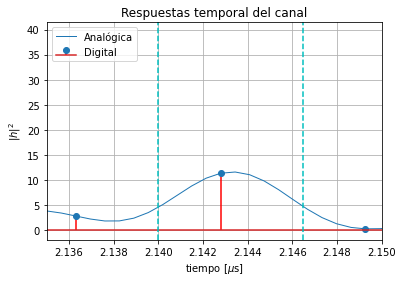

In [138]:
margen = 15
oversample = 10
ha_3, ta_3=genhl(Dsts, Fc, 70/delaySpread(Dsts),a_i, oversample, margen)
hd_3, td_3=genhl(Dsts, Fc, 70/delaySpread(Dsts),a_i, 1, margen)
print(70/delaySpread(Dsts))

plt.figure()
plt.plot(ta_3*1e6,abs(ha_3)**2,linewidth=1)
plt.stem(td_3*1e6,abs(hd_3)**2,'r')
plt.xlabel('tiempo [$\mu$s]')
plt.ylabel('$|h|^2$')
plt.title('Respuestas temporal del canal')
plt.grid()
plt.legend(['Analógica', 'Digital'])
#Medicion del tiempo de coherencia

plt.axvline(2.14,c = 'c',linestyle = '--')
plt.axvline(2.1465,c = 'c',linestyle = '--')
Tc_exp_3 = 2.1465e-6 - 2.14e-6
print("Tc_experimental = ",Tc_exp_3)
plt.xlim(2.135,2.15)

OBS: no es simétrica => para que lado tomo el ancho?
Podría tomar la mitad de lo graficado

Wc_experimental_2 = 30000.0 Hz


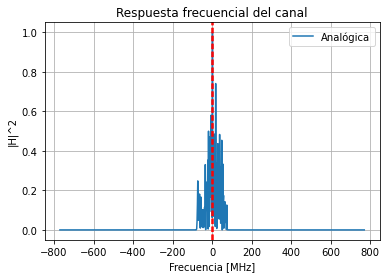

In [163]:
#Calculo de la FFT
Ha_3 = np.fft.fft(ha_3)
Ha_3 = np.fft.fftshift(Ha_3)
Ha_3 = Ha_3/np.max(Ha_3)

#Genero el vectores de frecuencias
fa_3 = np.fft.fftshift(np.fft.fftfreq(Ha_3.size, d=np.diff(ta_3)[0]))
plt.figure()
plt.plot(fa_3/1000000,np.abs(Ha_3)**2)
plt.xlabel('Frecuencia [MHz]')
plt.ylabel('|H|^2')
plt.title('Respuesta frecuencial del canal')
plt.grid()
plt.legend(['Analógica'])

#Medicion de la banda de coherencia
plt.axvline(0.8,c = 'r',linestyle = '--')
plt.axvline(2.8,c ='r',linestyle = '--')
# plt.xlim(50,60)
Wc_exp_3 = (np.abs(30000) + np.abs(-30000))/2
print("Wc_experimental_2 =",Wc_exp_3,"Hz")


¿A que clasificación corresponden estos casos? Muestre gráficos de la respuesta temporal y frecuencial para cada caso. 

-Caso 1: flat fading

-Caso 2: frecuency selective

-Caso 3: frecuency selective

Para el caso de flat fading, proponer mediciones que permitan verificar si se cumple el modelo estadístico de canal Rayleigh (pista: genere una cantidad suficiente de escenarios para poder tener un histograma de valores del modulo del tap del canal y ajústelos con la pdf apropiada)

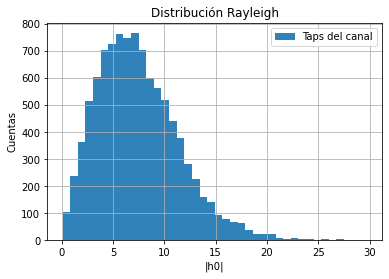

In [12]:
#Genero una distribución raylegih
from pickle import TRUE
from numpy import linspace
import scipy.stats as st
N = 10000
h0Ra = np.zeros(N)
for i in range(N):
    posRx = np.array([np.random.randint(-250, 250),np.random.randint(250, 750)]) #Muevo el receptor, de manera random
    Dsts,_ = genDists(S,posTx,posRx) #Genero las nuevas distancias
    a_i = -1 * np.ones(len(Dsts))     # El - es por la reflexión
    #Se podría dividir los a_i por la distancia a la que se encuentra, en un principio no lo haré
    hR, tR = genhl(Dsts, Fc,  0.01/delaySpread(Dsts), a_i, oversample, margen)
    h0Ra[i] = np.max(np.abs(hR))

#Quiero graficar un histrograma de la distribución Rayleigh, para eso necesito generar una cantidad de muestras de la distribución
#y luego graficar el histograma de esos valores

plt.figure()
plt.hist(h0Ra, alpha = 0.92, bins = 40)
#plt.hist(rician)
plt.title('Distribución Rayleigh')
plt.xlabel('|h0|')
plt.ylabel('Cuentas')
plt.grid()
plt.legend(['Taps del canal','Rayleigh'])


Repita la consigna para un canal tipo Rician (para esto debe modificar “artificialmente” el vector de atenuaciones de modo que haya un camino especular cuya energía sea K veces la energía de la sumatoria de los otros caminos) para 4 valores distintivos de
factor K.

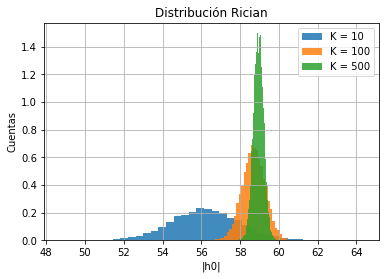

In [13]:
#Genero una distribución Rician
from pickle import TRUE
from numpy import linspace
import scipy.stats as st
N = 10000
lk = [10, 100, 500]
indice = 0
h0R = np.zeros((3,N))
for k in lk:
    #h0R[indice] = np.zeros(N)
    for i in range(N):
        posRx = np.array([np.random.randint(-250, 250),np.random.randint(250, 750)])
        Dsts,_ = genDists(S,posTx,posRx)
        a_i = -1 * np.ones(len(Dsts)) / (np.sqrt(k+1))     # El - es por la reflexión
        index_random = np.random.randint(0, len(a_i))   # Este será el camino más potente
        #index_random = 0
        a_i[index_random] = a_i[index_random] * np.sqrt(k)
        a_i[index_random] = np.sqrt((np.sum(a_i[0:])-a_i[index_random])*(np.sum(a_i[0:])-a_i[index_random])*k)
        #Se podría dividir los a_i por la distancia a la que se encuentra, en un principio no lo haré
        hR, tR = genhl(Dsts, Fc,  0.01/delaySpread(Dsts), a_i, oversample, margen)
        h0R[indice][i] = np.max(np.abs(hR))
    indice = indice + 1

    #Quiero graficar un histrograma de la distribución Rician, para eso necesito generar una cantidad de muestras de la distribución
    #y luego graficar el histograma de esos valores
    rician = st.rice.rvs(k, size = N)

plt.figure()
plt.hist(h0R[0], alpha = 0.85, bins = 40, density = True)
plt.hist(h0R[1], alpha = 0.85, bins = 40, density = True)
plt.hist(h0R[2], alpha = 0.85, bins = 40, density = True)
#plt.hist(rician)
plt.title('Distribución Rician')
plt.xlabel('|h0|')
plt.ylabel('Cuentas')
plt.grid()
plt.legend(['K = 10','K = 100', 'K = 500'])


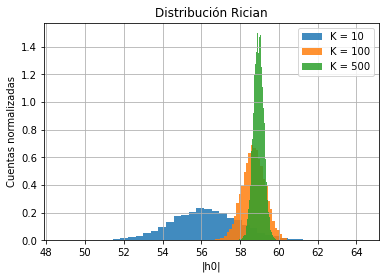

In [14]:
plt.figure()
plt.hist(h0R[0], alpha = 0.85, bins = 40, density = True)
plt.hist(h0R[1], alpha = 0.85, bins = 40, density = True)
plt.hist(h0R[2], alpha = 0.85, bins = 40, density = True)
#plt.hist(rician)
plt.title('Distribución Rician')
plt.xlabel('|h0|')
plt.ylabel('Cuentas normalizadas')
plt.grid()
plt.legend(['K = 10','K = 100', 'K = 500'])

Tambien para el caso (i) haga un mapa de “fuerza” del canal (|h0|2) para alguna region geografica a su elección y dé una estimación aproximada “a ojo” de la distancia de coherencia

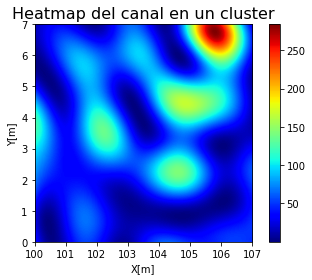

In [15]:
#Heatmap del canal
#Poner el receptor adentro de un cluster, que haya quilombo

Ns=np.array([20, 20, 20])   #nro. de reflectores por cluster
Rc=np.array([Diametro_de_clusters, Diametro_de_clusters, Diametro_de_clusters])   #diametro de los clusters en metros
Cc=np.array([[-50.0,250.0], [100,0.0], [200,250.0]])  #centros de los clusters
posTx = np.array([0,0])
posRx = np.array([0.0,500.0])
vmax = 60000/3600   #[m/s]

#Quiero un vector que vaya desde 1 hasta 10, con 50 elementos
cantidad_de_puntos = 250
corrimiento = np.linspace(1,1.5,cantidad_de_puntos)

# Generamos "clusters" y respectivas distancias/atenuaciones
S = genScat(Ns,Rc,Cc)
Dsts,_ = genDists(S,posTx,posRx)
a_i = -1*np.ones(np.size(Dsts))
matriz_ha_1 = np.zeros((cantidad_de_puntos,cantidad_de_puntos))


for i in range(cantidad_de_puntos):
    for j in range(cantidad_de_puntos):
        #Mantengo todo excepto la posición del receptor y las distancias
        posRx = np.array([100+corrimiento[i],0+corrimiento[j]])     #Muevo el receptor
        Dsts,_ = genDists(S,posTx,posRx)                              #Genero las nuevas distancias
        a_i = -1 * np.ones(len(Dsts))                                 #El - es por la reflexión
        #Se podría dividir los a_i por la distancia a la que se encuentra, en un principio no lo haré
        hh, th = genhl(Dsts, Fc,  0.01/delaySpread(Dsts), a_i, oversample, margen)
        hh_0 = np.max(np.abs(hh))
        matriz_ha_1[i][j] = hh_0*hh_0
        
#Grafico el heatmap
plt.figure()
#Quiero normalizar mi heatmap, para que los valores en x y en y vayan de 0 a 7 metros
plt.imshow(matriz_ha_1, cmap = 'jet', extent = [100,107,0,7])
plt.xlabel("X[m]", fontsize=10)
plt.ylabel("Y[m]", fontsize=10)
plt.colorbar()
plt.title('Heatmap del canal en un cluster', fontsize=16)
plt.show()

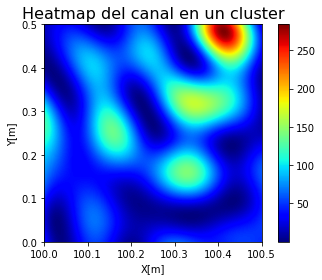

In [16]:
#Grafico el heatmap
plt.figure()
#Quiero normalizar mi heatmap, para que los valores en x y en y vayan de 0 a 7 metros
plt.imshow(matriz_ha_1, cmap = 'jet', extent = [100,100.5,0,0.5])
plt.xlabel("X[m]", fontsize=10)
plt.ylabel("Y[m]", fontsize=10)
plt.colorbar()
plt.title('Heatmap del canal en un cluster', fontsize=16)
plt.show()

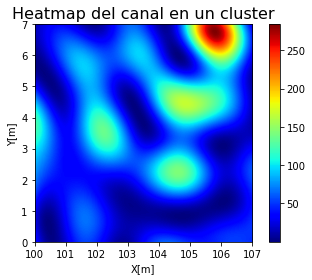

In [17]:
#Grafico el heatmap
plt.figure()
#Quiero normalizar mi heatmap, para que los valores en x y en y vayan de 0 a 7 metros
plt.imshow(matriz_ha_1, cmap = 'jet', extent = [100,107,0,7])
plt.xlabel("X[m]", fontsize=10)
plt.ylabel("Y[m]", fontsize=10)
plt.colorbar()
plt.title('Heatmap del canal en un cluster', fontsize=16)
plt.show()

Se busca caracterizar espectralmente el efecto Doppler

Utilizando un único cluster lo suficientemente grande y un receptor móvil dentro del mismo

Se desea evaluar como varía un canal inalambrico en el tiempo (efecto Doppler); en particular,
se busca caracterizar espectralmente el efecto Doppler y comparar los resultados
obtenidos con aquel que surge del modelo de Clarke.

In [11]:
#Utilizando un único cluster lo suficientemente grande y un receptor móvil dentro del mismo
#Quiero un vector que vaya desde 1 hasta 10, con 250 elementos

Ns=np.array([1000, 0, 0])   #nro. de reflectores por cluster
Diametro_de_clusters = 100 #aumenté el diametro del cluster
Rc=np.array([Diametro_de_clusters, Diametro_de_clusters, Diametro_de_clusters])   #diametro de los clusters en metros
Cc=np.array([[1000,0], [100,0.0], [200,250.0]])  #centros de los clusters
posTx = np.array([0,0])
posRx = np.array([1000,0])
# Generamos el cluster
S = genScat(Ns,Rc,Cc)
margen = 15
oversample = 10

vmax = 50            #50 m/s
T_coherencia =  4.59314977203926e-05
dt = 1e-03                   #dt < T_coherencia
cantidad_de_puntos = 1000   #En total me moveré 0.016 metros
corrimiento = vmax*dt        #5 [cm] de corrimiento
autocorrprom = np.zeros(cantidad_de_puntos)
autocorr = []
hh_0_vector = []

for k in range(5):
    for j in range(cantidad_de_puntos):
        #Mantengo todo excepto la posición del receptor y las distancias
        posRx = np.array([1000+corrimiento*j,0])                       #Muevo el receptor
        Dsts,_ = genDists(S,posTx,posRx)                              #Genero las nuevas distancias
        a_i = np.zeros(len(Dsts))
        #También debe modificar las atenuaciones de cada camino que en el caso del modelo de ray tracing se calculan como ai = -1/(d1+d2)
        for p in range(len(Dsts)):
            d1 = Dsts[p]                      #d1 la distancia entre transmisor y reflector(centro del reflector)
            d2 = _[p] - Dsts[p]                  #d2 la distancia entre reflector(centro del mismo) y receptor
            a_i[p] = -1/(d1+d2)            #atenuación de cada camino
        hh, th = genhl(Dsts, Fc,  0.01/delaySpread(Dsts), a_i, oversample, margen)
        if(k==0):
            hh_0_vector.append(hh[0])
        else:
            hh_0_vector[j] = hh[0]
        #Para la caracterizacion que se pide, parta de calcular la función de autocorrelación de ganancias de tap

    autocorrprom += np.correlate(hh_0_vector, hh_0_vector, mode='full')
    #Voy a vaciar los vectores
    hh_0_vector = np.zeros(cantidad_de_puntos)


UFuncTypeError: Cannot cast ufunc 'add' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Text(0.5, 1.0, 'Densidad espectral')

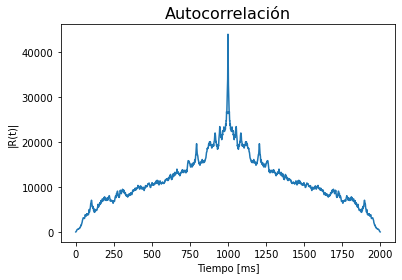

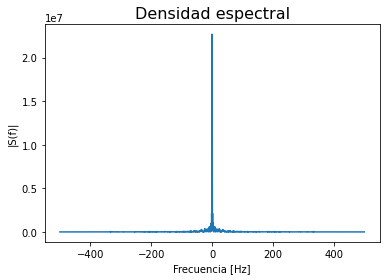

In [36]:
#Utilizando un único cluster lo suficientemente grande y un receptor móvil dentro del mismo

#Quiero un vector que vaya desde 1 hasta 10, con 250 elementos

Ns=np.array([1000, 0, 0])   #nro. de reflectores por cluster
Diametro_de_clusters = 100 #aumenté el diametro del cluster
Rc=np.array([Diametro_de_clusters, Diametro_de_clusters, Diametro_de_clusters])   #diametro de los clusters en metros
Cc=np.array([[1000,0], [100,0.0], [200,250.0]])  #centros de los clusters
posTx = np.array([0,0])
posRx = np.array([1000,0])
# Generamos el cluster
S = genScat(Ns,Rc,Cc)
margen = 15
oversample = 10

vmax = 50            #50 m/s
T_coherencia =  4.59314977203926e-05
dt = 1e-03                   #dt < T_coherencia
cantidad_de_puntos = 1000   #En total me moveré 0.016 metros
corrimiento = vmax*dt        #5 [cm] de corrimiento
autocorr = []
hh_0_vector = []

for k in range(5):
    for j in range(cantidad_de_puntos):
        #Mantengo todo excepto la posición del receptor y las distancias
        posRx = np.array([1000+corrimiento*j,0])                       #Muevo el receptor
        Dsts,_ = genDists(S,posTx,posRx)                              #Genero las nuevas distancias
        a_i = np.zeros(len(Dsts))
        #También debe modificar las atenuaciones de cada camino que en el caso del modelo de ray tracing se calculan como ai = -1/(d1+d2)
        for p in range(len(Dsts)):
            d1 = Dsts[p]                      #d1 la distancia entre transmisor y reflector(centro del reflector)
            d2 = _[p] - Dsts[p]                  #d2 la distancia entre reflector(centro del mismo) y receptor
            a_i[p] = -1/(d1+d2)            #atenuación de cada camino
        hh, th = genhl(Dsts, Fc,  0.01/delaySpread(Dsts), a_i, oversample, margen)
        hh_0 = np.max(np.abs(hh))
        if(k==0):
            hh_0_vector.append(hh_0)
        else:
            hh_0_vector[j] = hh_0
        #Para la caracterizacion que se pide, parta de calcular la función de autocorrelación de ganancias de tap
    autocorr.append(np.correlate(hh_0_vector, hh_0_vector, mode='full'))

    #En autocorrprom quiero guardar el promedio de las autocorr, en donde cada lista agregada en autocorr es una corrida
autocorrprom = []
for k in range(5):
    for l in range(int(len(autocorr[0]))):
        if(k == 0):
            autocorrprom.append(autocorr[k][l])
        else:
            autocorrprom[l] = autocorrprom[l] + autocorr[k][l]

plt.figure()
t = np.linspace(-dt*cantidad_de_puntos/2,dt*cantidad_de_puntos/2,cantidad_de_puntos*2-1)
# plt.plot(t*1e3,np.abs(autocorr[0]))
plt.plot(np.abs(autocorrprom))
plt.xlabel("Tiempo [ms]", fontsize=10)
plt.ylabel("|R(t)|", fontsize=10)
plt.title('Autocorrelación', fontsize=16)
dep = np.fft.fftshift(np.fft.fft(autocorrprom))
freq = np.fft.fftshift(np.fft.fftfreq(dep.size, d=dt))
#Plotearé la dep en función de la frecuencia
plt.figure()
plt.plot(freq, np.abs(dep))
plt.xlabel("Frecuencia [Hz]", fontsize=10)
plt.ylabel("|S(f)|", fontsize=10)
plt.title('Densidad espectral', fontsize=16)


Doppler shift =  16.666666666666668


(-33.333333333333336, 33.333333333333336)

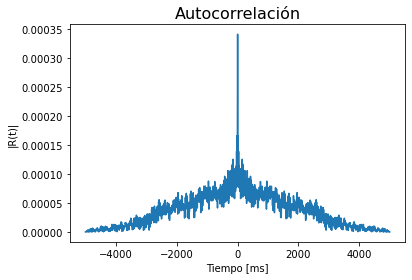

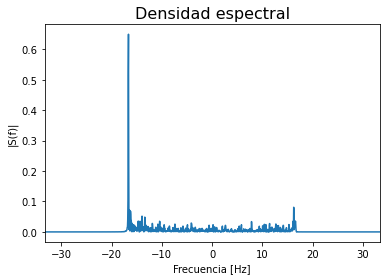

In [31]:
#Utilizando un único cluster lo suficientemente grande y un receptor móvil dentro del mismo
Ns=np.array([1000, 0, 0])   #nro. de reflectores por cluster
Diametro_de_clusters = 100 #aumenté el diametro del cluster
Rc=np.array([Diametro_de_clusters, Diametro_de_clusters, Diametro_de_clusters])   #diametro de los clusters en metros
Cc=np.array([[1000,0], [100,0.0], [200,250.0]])  #centros de los clusters
posTx = np.array([0,0])
posRx = np.array([1000,0])
# Generamos el cluster
S = genScat(Ns,Rc,Cc)
margen = 15
oversample = 10

vmax = 5                     #5 m/s
dt = 1e-03                   
cantidad_de_puntos = 10000   
corrimiento = vmax*dt        #0.5 [cm] de corrimiento, corrimiento total de 50metros
autocorr = []
hh_0_vector = []
cantidad_de_realizaciones = 30

for k in range(cantidad_de_realizaciones):
    for j in range(cantidad_de_puntos):
        #Mantengo todo excepto la posición del receptor y las distancias
        posRx = np.array([975+corrimiento*j,0])                       #Muevo el receptor
        Dsts,_ = genDists(S,posTx,posRx)                              #Genero las nuevas distancias
        a_i = np.zeros(len(Dsts))
        #También debe modificar las atenuaciones de cada camino que en el caso del modelo de ray tracing se calculan como ai = -1/(d1+d2)
        for p in range(len(Dsts)):
            d1 = Dsts[p]                      #d1 la distancia entre transmisor y reflector(centro del reflector)
            d2 = _[p] - Dsts[p]                  #d2 la distancia entre reflector(centro del mismo) y receptor
            a_i[p] = -1/(d1*d2)            #atenuación de cada camino
        hh, th = genhl(Dsts, Fc,  0.01/delaySpread(Dsts), a_i, oversample, margen)
        hh_0 = hh[np.argmax(np.abs(hh))]
        if(k==0):
            hh_0_vector.append(hh_0)
        else:
            hh_0_vector[j] = hh_0
        #Para la caracterizacion que se pide, parta de calcular la función de autocorrelación de ganancias de tap
    autocorr.append(np.correlate(hh_0_vector, hh_0_vector, mode='full'))

    #En autocorrprom quiero guardar el promedio de las autocorr, en donde cada lista agregada en autocorr es una corrida
autocorrprom = []
for k in range(cantidad_de_realizaciones):
    for l in range(int(len(autocorr[0]))):
        if(k == 0):
            autocorrprom.append(autocorr[k][l])
        else:
            autocorrprom[l] = autocorrprom[l] + autocorr[k][l]

plt.figure()
t = np.linspace(-dt*cantidad_de_puntos/2,dt*cantidad_de_puntos/2,cantidad_de_puntos*2-1)
plt.plot(t*1e3,np.abs(autocorrprom))
plt.xlabel("Tiempo [ms]", fontsize=10)
plt.ylabel("|R(t)|", fontsize=10)
plt.title('Autocorrelación', fontsize=16)
dep = np.fft.fftshift(np.fft.fft(autocorrprom))
freq = np.fft.fftshift(np.fft.fftfreq(dep.size, d=dt))
#Plotearé la dep en función de la frecuencia
plt.figure()
plt.plot(freq, np.abs(dep))
plt.xlabel("Frecuencia [Hz]", fontsize=10)
plt.ylabel("|S(f)|", fontsize=10)
plt.title('Densidad espectral', fontsize=16)
Ds = Fc*vmax/(3e8) #Doppler shift
print("Doppler shift = ", Ds)
plt.xlim(-Ds*2,Ds*2)

Doppler shift =  16.666666666666668


(-33.333333333333336, 33.333333333333336)

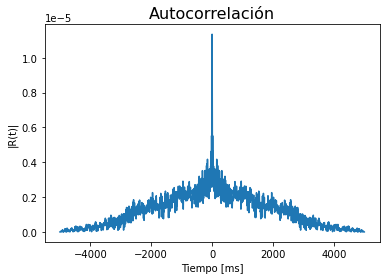

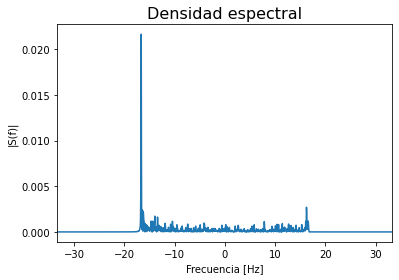

In [32]:
for i in range(len(autocorrprom)):
    autocorrprom[i] = autocorrprom[i]/cantidad_de_realizaciones

plt.figure()
t = np.linspace(-dt*cantidad_de_puntos/2,dt*cantidad_de_puntos/2,cantidad_de_puntos*2-1)
plt.plot(t*1e3,np.abs(autocorrprom))
plt.xlabel("Tiempo [ms]", fontsize=10)
plt.ylabel("|R(t)|", fontsize=10)
plt.title('Autocorrelación', fontsize=16)
plt.xlim(-Ds*2,Ds*2)
dep = np.fft.fftshift(np.fft.fft(autocorrprom))
freq = np.fft.fftshift(np.fft.fftfreq(dep.size, d=dt))
#Plotearé la dep en función de la frecuencia
plt.figure()
plt.plot(freq, np.abs(dep))
plt.xlabel("Frecuencia [Hz]", fontsize=10)
plt.ylabel("|S(f)|", fontsize=10)
plt.title('Densidad espectral', fontsize=16)
Ds = Fc*vmax/(3e8) #Doppler shift
print("Doppler shift = ", Ds)
plt.xlim(-Ds*2,Ds*2)

Doppler shift =  16.666666666666668


(-33.333333333333336, 33.333333333333336)

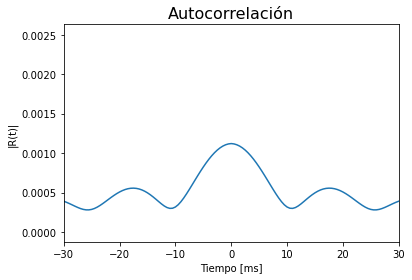

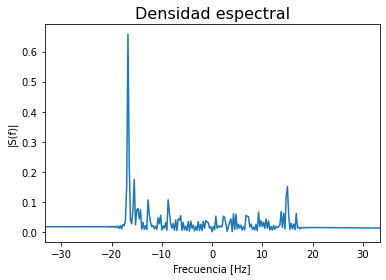

In [29]:
for i in range(len(autocorrprom)):
    autocorrprom[i] = autocorrprom[i]*np.max(np.abs(autocorrprom))

plt.figure()
t = np.linspace(-dt*cantidad_de_puntos/2,dt*cantidad_de_puntos/2,cantidad_de_puntos*2-1)
plt.plot(t*1e3,np.abs(autocorrprom))
plt.xlabel("Tiempo [ms]", fontsize=10)
plt.ylabel("|R(t)|", fontsize=10)
plt.title('Autocorrelación', fontsize=16)
plt.xlim(-30,30)
dep = np.fft.fftshift(np.fft.fft(autocorrprom))
freq = np.fft.fftshift(np.fft.fftfreq(dep.size, d=dt))
#Plotearé la dep en función de la frecuencia
plt.figure()
plt.plot(freq, np.abs(dep))
plt.xlabel("Frecuencia [Hz]", fontsize=10)
plt.ylabel("|S(f)|", fontsize=10)
plt.title('Densidad espectral', fontsize=16)
Ds = Fc*vmax/(3e8) #Doppler shift
print("Doppler shift = ", Ds)
plt.xlim(-Ds*2,Ds*2)

Doppler shift =  55.55555555555556


(-111.11111111111111, 111.11111111111111)

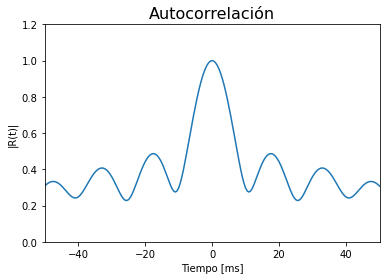

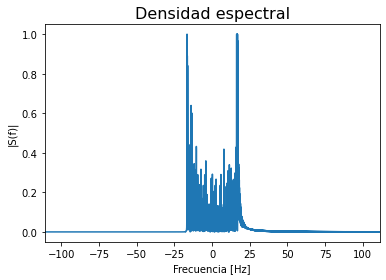

In [167]:
autocorrprom2 = []
for i in range(len(autocorrprom)):
    autocorrprom2.append(autocorrprom[i]/np.max(np.abs(autocorrprom)))

plt.figure()
t = np.linspace(-dt*cantidad_de_puntos/2,dt*cantidad_de_puntos/2,cantidad_de_puntos*2-1)
plt.plot(t*1e3,np.abs(autocorrprom2))
plt.xlabel("Tiempo [ms]", fontsize=10)
plt.ylabel("|R(t)|", fontsize=10)
plt.title('Autocorrelación', fontsize=16)
plt.xlim(-50,50)
plt.ylim(0,1.2)
dep2 = np.fft.fftshift(np.fft.fft(autocorrprom2))
freq = np.fft.fftshift(np.fft.fftfreq(dep2.size, d=dt))
for i in range(len(dep2)):
    dep2[i] = dep2[i]/np.max(np.abs(dep2))
#Plotearé la dep en función de la frecuencia
plt.figure()
plt.plot(freq, np.abs(dep2))
plt.xlabel("Frecuencia [Hz]", fontsize=10)
plt.ylabel("|S(f)|", fontsize=10)
plt.title('Densidad espectral', fontsize=16)
Ds = Fc*vmax/(3e8) #Doppler shift
print("Doppler shift = ", Ds)
plt.xlim(-21,21)

Doppler shift =  16.666666666666668


(-21.0, 21.0)

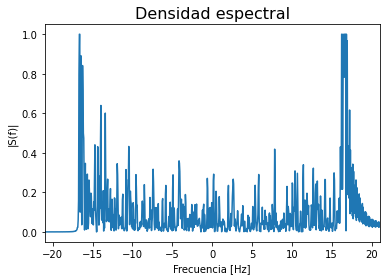

In [172]:
plt.figure()
plt.plot(freq, np.abs(dep2))
plt.xlabel("Frecuencia [Hz]", fontsize=10)
plt.ylabel("|S(f)|", fontsize=10)
plt.title('Densidad espectral', fontsize=16)
vmax = 5
Ds = Fc*vmax/(3e8) #Doppler shift
print("Doppler shift = ", Ds)
plt.xlim(-21,21)

In [179]:
#Distancia de coherencia de 0,22m
velocidad = 5
Tiempo_de_coh = 0.20/(velocidad)
print(Tiempo_de_coh)

0.04


In [175]:
print(1/(4*16.66))

0.015006002400960384


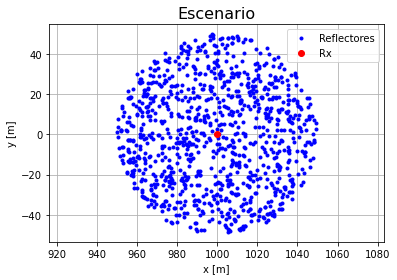

In [192]:
#Utilizando un único cluster lo suficientemente grande y un receptor móvil dentro del mismo
Ns=np.array([1000, 0, 0])   #nro. de reflectores por cluster
Diametro_de_clusters = 100 #aumenté el diametro del cluster
Rc=np.array([Diametro_de_clusters, Diametro_de_clusters, Diametro_de_clusters])   #diametro de los clusters en metros
Cc=np.array([[1000,0], [100,0.0], [200,250.0]])  #centros de los clusters
posTx = np.array([0,0])
posRx = np.array([1000,0])
# Generamos el cluster
S = genScat(Ns,Rc,Cc)
margen = 15
oversample = 10

vmax = 5                     #5 m/s
dt = 1e-03                   
cantidad_de_puntos = 10000   
corrimiento = vmax*dt        #0.5 [cm] de corrimiento, corrimiento total de 50metros
autocorr = []
hh_0_vector = []
cantidad_de_realizaciones = 30


from cProfile import label


plt.figure()
for s in S:
    plt.plot(s[0],s[1],'b.')

plt.plot(1001,0,'b.',label='Reflectores')
#plt.plot(posTx[0],posTx[1],'go',label='Tx')
plt.plot(posRx[0],posRx[1],'ro',label='Rx')
plt.axis('equal')
plt.xlabel("x [m]", fontsize=10)
plt.ylabel("y [m]", fontsize=10)
plt.title('Escenario', fontsize=16)
plt.legend()
plt.grid()
